### Hyperparameters:
| Hyperparameter       | Value   |
|----------------------|---------|
| num-filters          | 32      |
| num-bilstm-layer     | 2       |
| output-lstm-dim      | 64      |
| decay-rate           | 0.8     |
| learning-rate        | 0.01    |
| miniBatchSize        | 256     |
| filter-size          | 10 × 1  |
| input-lstm-dim       | 100     |
| L2Regularization     | 0.001   |
| optimizer            | Adam    |
| dropout              | 0.25    |
| maxEpochs            | 500     |

In [1]:
import sys
sys.path.append("..")

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 15
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

## CNN-BiLSTM

In [100]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(1, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [101]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(1, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [102]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [103]:
model = CNNBiLSTM(input_dim=len(features))

In [104]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [105]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=decay_rate,  # 0.8
    patience=1,         # Reduce LR after 5 epochs without improvement
    min_lr=1e-5,        # Minimum learning rate
)

In [106]:
best_val_loss = float('inf')
patience = 20
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(lstm.state_dict(), '../models/lstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 188229
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 170.85it/s]


Epoch [1/500] - Train Loss: 1.365941, Val Loss: 20.948408
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.12it/s]


Epoch [2/500] - Train Loss: 1.184138, Val Loss: 19.280329
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.81it/s]


Epoch [3/500] - Train Loss: 1.074299, Val Loss: 17.082872
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 167.77it/s]


Epoch [4/500] - Train Loss: 0.821842, Val Loss: 12.431942
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.51it/s]


Epoch [5/500] - Train Loss: 0.463866, Val Loss: 7.185525
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.48it/s]


Epoch [6/500] - Train Loss: 0.296124, Val Loss: 3.992298
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.30it/s]


Epoch [7/500] - Train Loss: 0.168892, Val Loss: 1.826312
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.91it/s]


Epoch [8/500] - Train Loss: 0.089008, Val Loss: 0.657958
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.96it/s]


Epoch [9/500] - Train Loss: 0.067291, Val Loss: 0.400087
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 185.22it/s]


Epoch [10/500] - Train Loss: 0.062249, Val Loss: 0.663686
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.89it/s]


Epoch [11/500] - Train Loss: 0.098148, Val Loss: 0.248908
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.54it/s]


Epoch [12/500] - Train Loss: 0.073159, Val Loss: 1.038377
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.90it/s]


Epoch [13/500] - Train Loss: 0.033479, Val Loss: 0.322244
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 150.74it/s]


Epoch [14/500] - Train Loss: 0.025378, Val Loss: 0.395058
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 172.67it/s]


Epoch [15/500] - Train Loss: 0.020026, Val Loss: 0.513748
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.98it/s]


Epoch [16/500] - Train Loss: 0.018884, Val Loss: 0.295722
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 181.92it/s]


Epoch [17/500] - Train Loss: 0.022844, Val Loss: 0.798356
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 181.40it/s]


Epoch [18/500] - Train Loss: 0.019823, Val Loss: 0.276000
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.50it/s]


Epoch [19/500] - Train Loss: 0.023402, Val Loss: 0.905077
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 180.06it/s]


Epoch [20/500] - Train Loss: 0.021385, Val Loss: 0.227620
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 182.07it/s]


Epoch [21/500] - Train Loss: 0.019589, Val Loss: 0.885615
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.86it/s]


Epoch [22/500] - Train Loss: 0.013448, Val Loss: 0.312873
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.79it/s]


Epoch [23/500] - Train Loss: 0.011015, Val Loss: 0.632665
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.59it/s]


Epoch [24/500] - Train Loss: 0.010558, Val Loss: 0.381161
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 179.79it/s]


Epoch [25/500] - Train Loss: 0.011211, Val Loss: 0.745350
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 182.08it/s]


Epoch [26/500] - Train Loss: 0.012328, Val Loss: 0.346969
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 168.48it/s]


Epoch [27/500] - Train Loss: 0.016885, Val Loss: 0.884671
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 183.17it/s]


Epoch [28/500] - Train Loss: 0.019932, Val Loss: 0.230544
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 182.36it/s]


Epoch [29/500] - Train Loss: 0.025236, Val Loss: 0.960068
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 182.73it/s]


Epoch [30/500] - Train Loss: 0.023256, Val Loss: 0.171407
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 168.85it/s]


Epoch [31/500] - Train Loss: 0.018664, Val Loss: 0.849796
Epoch 32/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 172.25it/s]


Epoch [32/500] - Train Loss: 0.013663, Val Loss: 0.266640
Epoch 33/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 181.31it/s]


Epoch [33/500] - Train Loss: 0.010915, Val Loss: 0.707790
Epoch 34/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 182.07it/s]


Epoch [34/500] - Train Loss: 0.008597, Val Loss: 0.375077
Epoch 35/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 151.22it/s]


Epoch [35/500] - Train Loss: 0.007209, Val Loss: 0.626732
Epoch 36/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 156.86it/s]


Epoch [36/500] - Train Loss: 0.006880, Val Loss: 0.483659
Epoch 37/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.47it/s]


Epoch [37/500] - Train Loss: 0.007477, Val Loss: 0.657245
Epoch 38/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 182.14it/s]


Epoch [38/500] - Train Loss: 0.008961, Val Loss: 0.408896
Epoch 39/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.81it/s]


Epoch [39/500] - Train Loss: 0.012219, Val Loss: 0.807137
Epoch 40/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.65it/s]


Epoch [40/500] - Train Loss: 0.017690, Val Loss: 0.261009
Epoch 41/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 181.80it/s]


Epoch [41/500] - Train Loss: 0.026389, Val Loss: 0.973184
Epoch 42/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 179.47it/s]


Epoch [42/500] - Train Loss: 0.031717, Val Loss: 0.140219
Epoch 43/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 181.56it/s]


Epoch [43/500] - Train Loss: 0.025499, Val Loss: 1.047672
Epoch 44/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 170.44it/s]


Epoch [44/500] - Train Loss: 0.017597, Val Loss: 0.237228
Epoch 45/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.24it/s]


Epoch [45/500] - Train Loss: 0.009057, Val Loss: 0.754741
Epoch 46/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.84it/s]


Epoch [46/500] - Train Loss: 0.006517, Val Loss: 0.476592
Epoch 47/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 164.41it/s]


Epoch [47/500] - Train Loss: 0.005735, Val Loss: 0.558245
Epoch 48/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 179.27it/s]


Epoch [48/500] - Train Loss: 0.005244, Val Loss: 0.565955
Epoch 49/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 179.23it/s]


Epoch [49/500] - Train Loss: 0.005684, Val Loss: 0.612649
Epoch 50/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 183.39it/s]


Epoch [50/500] - Train Loss: 0.005799, Val Loss: 0.581180
Epoch 51/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.67it/s]


Epoch [51/500] - Train Loss: 0.005558, Val Loss: 0.609992
Epoch 52/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 180.93it/s]


Epoch [52/500] - Train Loss: 0.006261, Val Loss: 0.480042
Epoch 53/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 176.07it/s]


Epoch [53/500] - Train Loss: 0.009912, Val Loss: 0.787894
Epoch 54/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 180.96it/s]


Epoch [54/500] - Train Loss: 0.011564, Val Loss: 0.273852
Epoch 55/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 175.90it/s]


Epoch [55/500] - Train Loss: 0.014863, Val Loss: 0.827883
Epoch 56/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 179.23it/s]


Epoch [56/500] - Train Loss: 0.016815, Val Loss: 0.208257
Epoch 57/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 181.14it/s]


Epoch [57/500] - Train Loss: 0.015811, Val Loss: 0.796324
Epoch 58/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 113.02it/s]


Epoch [58/500] - Train Loss: 0.016664, Val Loss: 0.222214
Epoch 59/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 176.43it/s]


Epoch [59/500] - Train Loss: 0.014281, Val Loss: 0.881302
Epoch 60/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 150.38it/s]


Epoch [60/500] - Train Loss: 0.011481, Val Loss: 0.287347
Epoch 61/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.75it/s]


Epoch [61/500] - Train Loss: 0.008585, Val Loss: 0.741832
Epoch 62/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 184.81it/s]

Epoch [62/500] - Train Loss: 0.006902, Val Loss: 0.410200
Early stopping triggered after epoch 62

Best validation loss: 0.140219


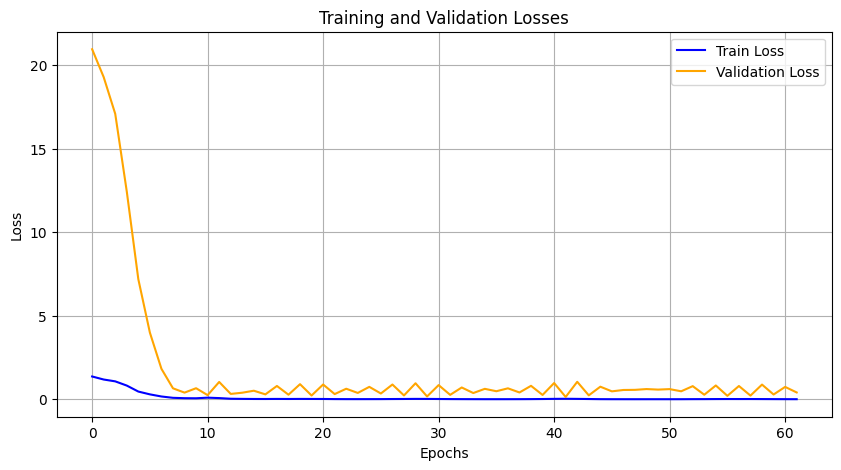

In [107]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [108]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.180100


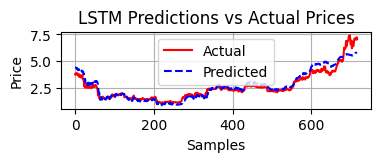

In [114]:
# plot predictions vs targets
plt.figure(figsize=(4, 1))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()